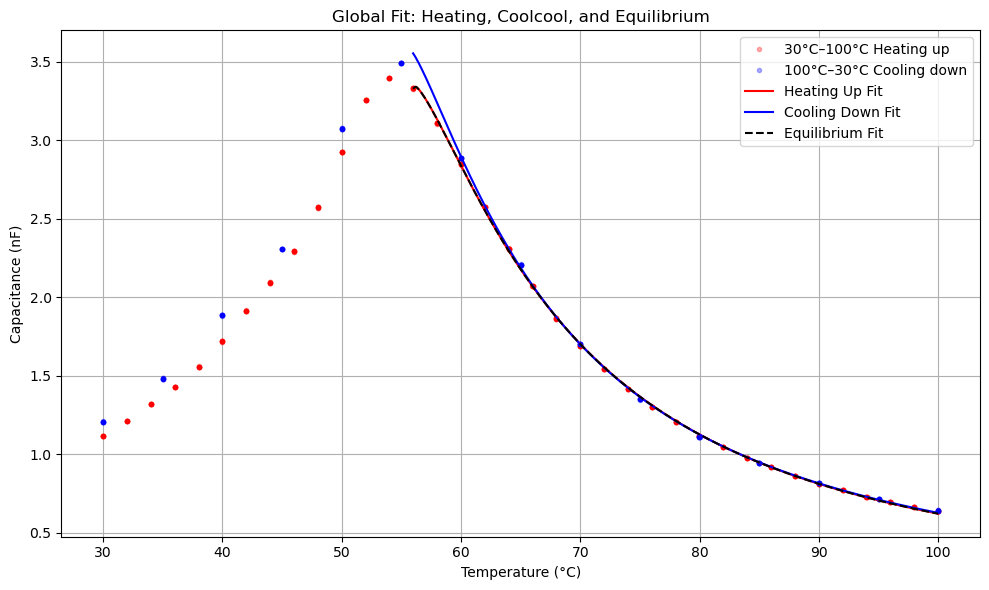

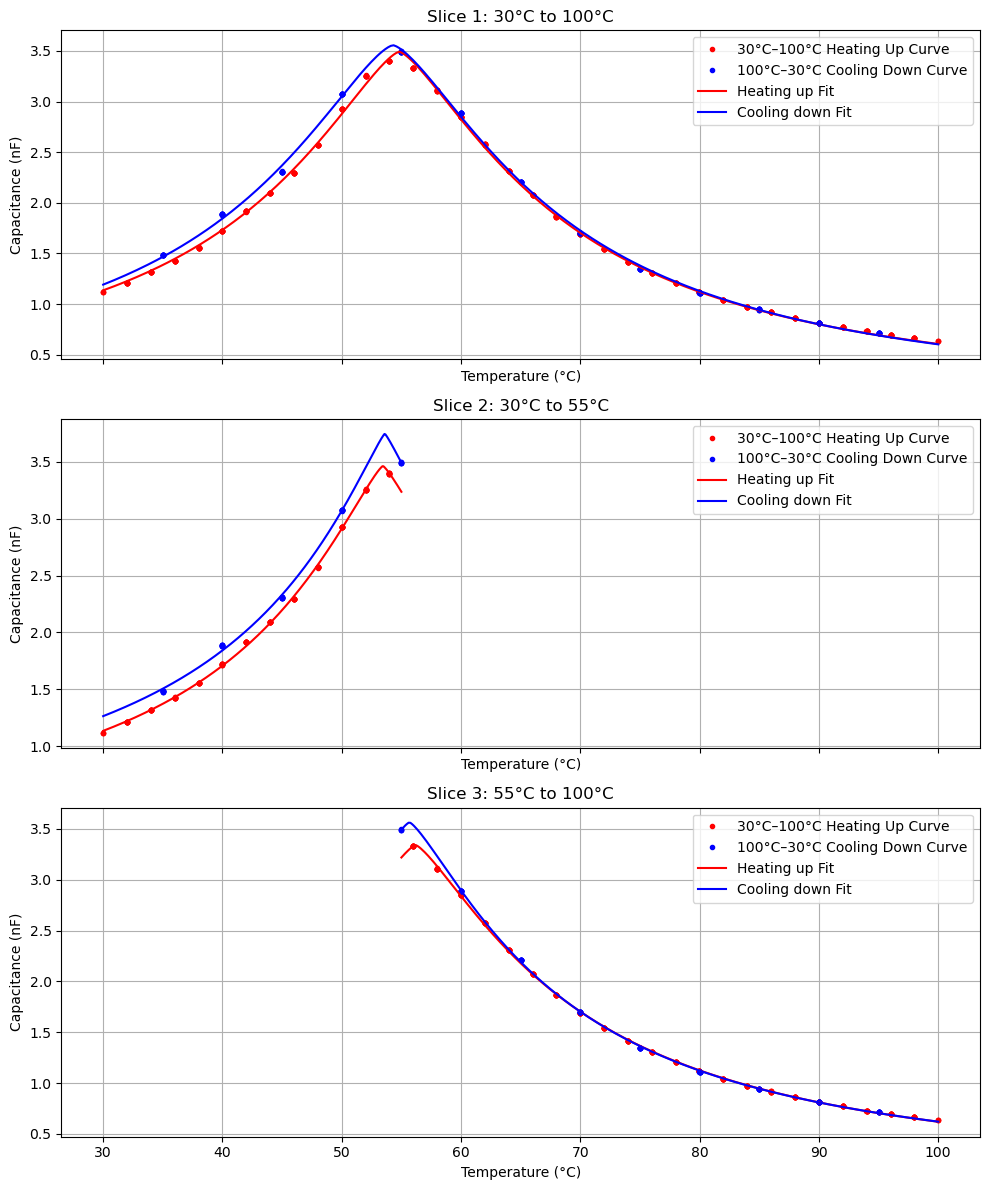


--- Global Fit Parameters ---
Heating Fit:     Cmax = 3.3422 nF | kappa = 0.03089 | Tc = 56.20°C | gamma = 1.311
Coolcool Fit:    Cmax = 3.5768 nF | kappa = 0.03655 | Tc = 55.73°C | gamma = 1.282
Equilibrium Fit: Cmax = 3.3419 nF | kappa = 0.03085 | Tc = 56.20°C | gamma = 1.311

--- Slice Fit Parameters ---
Slice 1 Heating: Cmax = 3.4920 nF | kappa = 0.02424 | Tc = 54.82°C | gamma = 1.385
Slice 1 Coolcool: Cmax = 3.5561 nF | kappa = 0.02053 | Tc = 54.30°C | gamma = 1.432
Slice 2 Heating: Cmax = 3.4633 nF | kappa = 0.04069 | Tc = 53.45°C | gamma = 1.242
Slice 2 Coolcool: Cmax = 3.7467 nF | kappa = 0.04962 | Tc = 53.61°C | gamma = 1.163
Slice 3 Heating: Cmax = 3.3411 nF | kappa = 0.03054 | Tc = 56.18°C | gamma = 1.314
Slice 3 Coolcool: Cmax = 3.5640 nF | kappa = 0.03453 | Tc = 55.67°C | gamma = 1.298

--- Tail Fits After Peak ---
Heating Tail Fit:   Cmax = 3.3422 nF | kappa = 0.03089 | Tc = 56.20°C | gamma = 1.311
Coolcool Tail Fit:  Cmax = 3.5768 nF | kappa = 0.03655 | Tc = 55.73°C | g

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- CONFIGURATION ---
filename_heat = 'Data/30_100T_2dT.lvm'
filename_cool = 'Data/100_30T_5dT.lvm'
delimiter = '\t'

slices = [
    (min(30, 100), max(30, 100)),  # Full sweep slice
    (30, 55),
    (55, 100),
]

# --- MODEL ---
def C_thermo(T, Cmax, kappa, Tc, gamma):
    return Cmax / (1 + kappa * np.abs(T - Tc)**gamma)

# --- LOAD DATA ---
data_heat = np.loadtxt(filename_heat, delimiter=delimiter)
t_heat, T_heat, C_heat_nF = data_heat[:, 0], data_heat[:, 1], data_heat[:, 2]
C_heat = C_heat_nF * 1e-9

data_cool = np.loadtxt(filename_cool, delimiter=delimiter)
t_cool, T_cool, C_cool_nF = data_cool[:, 0], data_cool[:, 1], data_cool[:, 2]
C_cool = C_cool_nF * 1e-9

# --- GLOBAL PEAK TEMP ---
T_peak_heat = T_heat[np.argmax(C_heat)]
T_peak_cool = T_cool[np.argmax(C_cool)]
T_peak = np.mean([T_peak_heat, T_peak_cool])

T_fit_heat = T_heat[T_heat > T_peak]
C_fit_heat = C_heat[T_heat > T_peak]
T_fit_cool = T_cool[T_cool > T_peak]
C_fit_cool = C_cool[T_cool > T_peak]

T_min_global = max(np.min(T_fit_heat), np.min(T_fit_cool))
T_max_global = min(np.max(T_fit_heat), np.max(T_fit_cool))

T_eq = T_heat[(T_heat > T_min_global) & (T_heat < T_max_global)]
C_eq = C_heat[(T_heat > T_min_global) & (T_heat < T_max_global)]

p0 = [np.max(C_eq), 0.01, T_peak, 1.5]

# --- Global Fits ---
popt_heat, _ = curve_fit(C_thermo, T_fit_heat, C_fit_heat, p0=p0)
popt_cool, _ = curve_fit(C_thermo, T_fit_cool, C_fit_cool, p0=p0)
popt_eq, _ = curve_fit(C_thermo, T_eq, C_eq, p0=p0)

# --- Global Plot ---
T_plot = np.linspace(T_min_global, T_max_global, 500)

plt.figure(figsize=(10, 6))
plt.plot(T_heat, C_heat * 1e9, 'r.', alpha=0.3, label='30°C–100°C Heating up')
plt.plot(T_cool, C_cool * 1e9, 'b.', alpha=0.3, label='100°C–30°C Cooling down')
plt.plot(T_plot, C_thermo(T_plot, *popt_heat) * 1e9, 'r-', label='Heating Up Fit')
plt.plot(T_plot, C_thermo(T_plot, *popt_cool) * 1e9, 'b-', label='Cooling Down Fit')
plt.plot(T_plot, C_thermo(T_plot, *popt_eq) * 1e9, 'k--', label='Equilibrium Fit')
plt.xlabel("Temperature (°C)")
plt.ylabel("Capacitance (nF)")
plt.title("Global Fit: Heating, Coolcool, and Equilibrium")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Slice Fits ---
fig, axs = plt.subplots(len(slices), 1, figsize=(10, 4 * len(slices)), sharex=True)
if len(slices) == 1:
    axs = [axs]

slice_fit_params = []

for idx, (T_min, T_max) in enumerate(slices):
    ax = axs[idx]
    ax.set_title(f"Slice {idx+1}: {T_min}°C to {T_max}°C")

    mask_heat = (T_heat > T_min) & (T_heat < T_max)
    T_slice_heat, C_slice_heat = T_heat[mask_heat], C_heat[mask_heat]

    mask_cool = (T_cool > T_min) & (T_cool < T_max)
    T_slice_cool, C_slice_cool = T_cool[mask_cool], C_cool[mask_cool]

    ax.plot(T_slice_heat, C_slice_heat * 1e9, 'r.', label='30°C–100°C Heating Up Curve')
    ax.plot(T_slice_cool, C_slice_cool * 1e9, 'b.', label='100°C–30°C Cooling Down Curve')

    try:
        popt_su, _ = curve_fit(C_thermo, T_slice_heat, C_slice_heat, p0=p0, maxfev=5000)
        T_fit = np.linspace(T_min, T_max, 300)
        ax.plot(T_fit, C_thermo(T_fit, *popt_su) * 1e9, 'r-', label='Heating up Fit')
        slice_fit_params.append((f"Slice {idx+1} Heating", popt_su))
    except:
        slice_fit_params.append((f"Slice {idx+1} Heating", None))

    try:
        popt_sd, _ = curve_fit(C_thermo, T_slice_cool, C_slice_cool, p0=p0, maxfev=5000)
        T_fit = np.linspace(T_min, T_max, 300)
        ax.plot(T_fit, C_thermo(T_fit, *popt_sd) * 1e9, 'b-', label='Cooling down Fit')
        slice_fit_params.append((f"Slice {idx+1} Coolcool", popt_sd))
    except:
        slice_fit_params.append((f"Slice {idx+1} Coolcool", None))

    ax.set_ylabel("Capacitance (nF)")
    ax.set_xlabel("Temperature (°C)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Tail (Decreasing) Fits ---
try:
    popt_tail_heat, _ = curve_fit(C_thermo, T_fit_heat, C_fit_heat, p0=p0)
except:
    popt_tail_heat = None

try:
    popt_tail_cool, _ = curve_fit(C_thermo, T_fit_cool, C_fit_cool, p0=p0)
except:
    popt_tail_cool = None

# --- PRINT FIT PARAMETERS ---
def format_params(popt):
    if popt is None:
        return "Fit failed"
    Cmax, kappa, Tc, gamma = popt
    return (f"Cmax = {Cmax*1e9:.4f} nF | "
            f"kappa = {kappa:.5f} | Tc = {Tc:.2f}°C | "
            f"gamma = {gamma:.3f}")

print("\n--- Global Fit Parameters ---")
print(f"Heating Fit:     {format_params(popt_heat)}")
print(f"Coolcool Fit:    {format_params(popt_cool)}")
print(f"Equilibrium Fit: {format_params(popt_eq)}")

print("\n--- Slice Fit Parameters ---")
for label, popt in slice_fit_params:
    print(f"{label}: {format_params(popt)}")

print("\n--- Tail Fits After Peak ---")
print(f"Heating Tail Fit:   {format_params(popt_tail_heat)}")
print(f"Coolcool Tail Fit:  {format_params(popt_tail_cool)}")
